# Загрузка необходимых библиотек

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import zipfile
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Загрузка исходных данных

In [ ]:
# прописываем путь к архиву
zip_file = '/content/drive/MyDrive/DS_identity_emotions/input_data/redact_clean.zip'

# распакуем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
# определим папки с данными, теперь итоговые изображения находятся в папке redact
train_dir = Path().parent / "redact"

train_anger_dir = train_dir / 'anger'
train_contempt_dir = train_dir / 'contempt'
train_disgust_dir = train_dir / 'disgust'
train_fear_dir = train_dir / 'fear'
train_happy_dir = train_dir / 'happy'
train_neutral_dir = train_dir / 'neutral'
train_sad_dir = train_dir / 'sad'
train_surprise_dir = train_dir / 'surprise'
train_uncertain_dir = train_dir / 'uncertain'

In [ ]:
def show_catsdogs(images, labels, predicted_labels=None, row=False, title=""):
    '''Функция для отображения изображений'''
    names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear", 4: "happy", 
             5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}
    fig = plt.figure(figsize=(10, 3 if row else 10))
    st = fig.suptitle(title, fontsize="x-large")
    n = 5 if row else 16
    for i in range(n):
        if not row:
            plt.subplot(4,4, i+1)
        else:
            plt.subplot(1,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[np.argmax(labels[i])]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[np.argmax(labels[i])]}")

#VGG 19

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Подготовка входных данных

In [ ]:
BATCH_SIZE = 128

In [ ]:
image_gen_no_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)
sample_no_aug = image_gen_no_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(128,128),
                                                     class_mode='categorical',
                                                     subset = "training",
                                                     seed=123
                                                     )

Found 38569 images belonging to 9 classes.


In [ ]:
# а теперь мы попросим его изменять изображение на лету, добавляя небольшие повороты + отражения по горизонтали
image_gen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # максимальный угол поворота
    horizontal_flip=True, # случайное отражение по горизонтали
    fill_mode="nearest", # чем заполнять пробелы
    validation_split=0.2  # соотношение тренировочных/валидационных данных = 0.8/0.2
    ) 



train_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=train_dir,
                                                   shuffle=True,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   subset = "training",
                                                   seed = 123)  # 80%

val_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=train_dir,
                                                 shuffle=False,
                                                 target_size=(128,128),
                                                 class_mode='categorical',
                                                 subset = "validation",
                                                 seed = 123)  # 20%


Found 38569 images belonging to 9 classes.
Found 9639 images belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


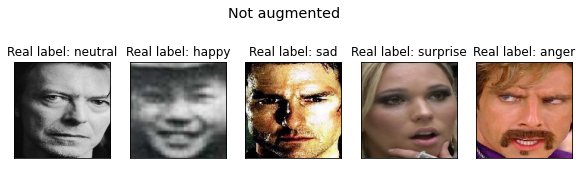

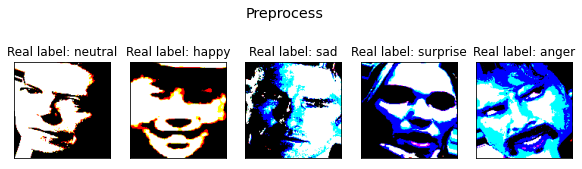

In [ ]:
sample_images, sample_labels = next(sample_no_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Not augmented")
sample_images, sample_labels = next(train_data_gen)
show_catsdogs(sample_images, sample_labels, row=True, title="Preprocess")

##Загрузка архитектуры обученной модели

###Замерим время инференса

In [ ]:
sample_images, sample_labels = next(val_data_gen)
test_img = sample_images[0][None,...]
test_img.shape

(1, 128, 128, 3)

In [ ]:
%%time

predictions = model.predict(test_img)

CPU times: user 50.8 ms, sys: 3.92 ms, total: 54.7 ms
Wall time: 63.8 ms


In [ ]:
%%timeit -n 10 -r 10

predictions = model.predict(test_img)

10 loops, best of 10: 44.6 ms per loop


In [ ]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- vgg19
all_base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
all_base_model.trainable = True # размораживаем всю базовую модель

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
model_all = tf.keras.Sequential([
  all_base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')  # 9 - кол-во классов
])

model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

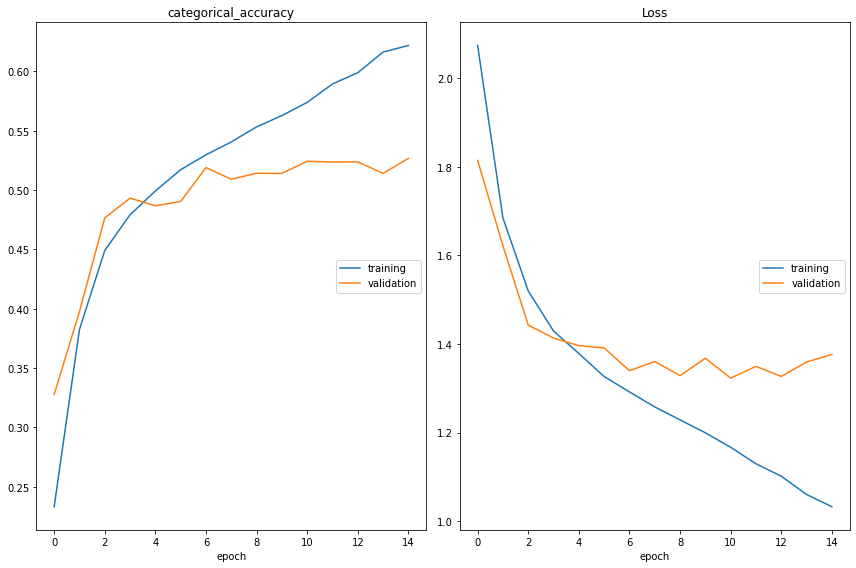

categorical_accuracy
	training         	 (min:    0.233, max:    0.622, cur:    0.622)
	validation       	 (min:    0.328, max:    0.527, cur:    0.527)
Loss
	training         	 (min:    1.033, max:    2.074, cur:    1.033)
	validation       	 (min:    1.323, max:    1.815, cur:    1.376)
302/302 [==============================] - 462s 2s/step - loss: 1.0327 - categorical_accuracy: 0.6219 - val_loss: 1.3763 - val_categorical_accuracy: 0.5267


In [ ]:
EPOCHS = 15
history_all = model_all.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [ ]:
model_all.save('./model_vgg19_all/1')

INFO:tensorflow:Assets written to: ./model_vgg19_all/1/assets


In [ ]:
!zip -r model_vgg19_all.zip model_vgg19_all

  adding: model_vgg19_all/ (stored 0%)
  adding: model_vgg19_all/1/ (stored 0%)
  adding: model_vgg19_all/1/saved_model.pb (deflated 91%)
  adding: model_vgg19_all/1/assets/ (stored 0%)
  adding: model_vgg19_all/1/keras_metadata.pb (deflated 96%)
  adding: model_vgg19_all/1/variables/ (stored 0%)
  adding: model_vgg19_all/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_vgg19_all/1/variables/variables.index (deflated 75%)


In [ ]:
model_all.save('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_all')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/vgg19_all/assets


In [ ]:
output_weights = Path("/content/drive/My Drive/weights_VGG19")
output_weights.mkdir(exist_ok=True)
file_name_weights = 'weights_VGG19.h5'
cpt_path_weights = str(output_weights / file_name_weights)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_all')

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    cpt_path_weights,
    monitor='val_categorical_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

#Продолжение обучения модели VGG19

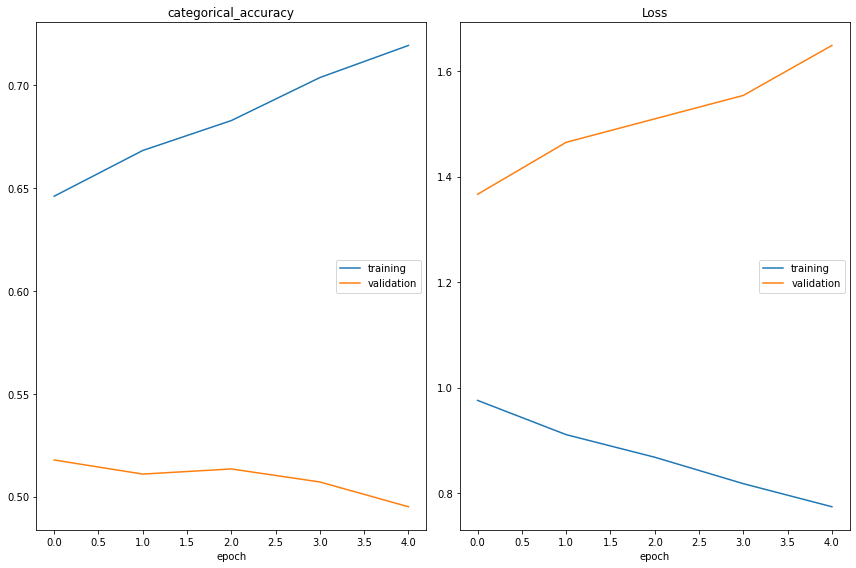

categorical_accuracy
	training         	 (min:    0.646, max:    0.719, cur:    0.719)
	validation       	 (min:    0.495, max:    0.518, cur:    0.495)
Loss
	training         	 (min:    0.774, max:    0.976, cur:    0.774)
	validation       	 (min:    1.366, max:    1.648, cur:    1.648)

Epoch 5: val_categorical_accuracy did not improve from 0.51779
302/302 [==============================] - 412s 1s/step - loss: 0.7743 - categorical_accuracy: 0.7193 - val_loss: 1.6483 - val_categorical_accuracy: 0.4951


In [ ]:
EPOCHS = 5
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint])

Дальнейшее обучение модели бессмысленно, т.к. точность только падает. Перегрузим модель заново и попробуем уменьшить скорость обучения.

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_all')

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    cpt_path_weights,
    monitor='val_categorical_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

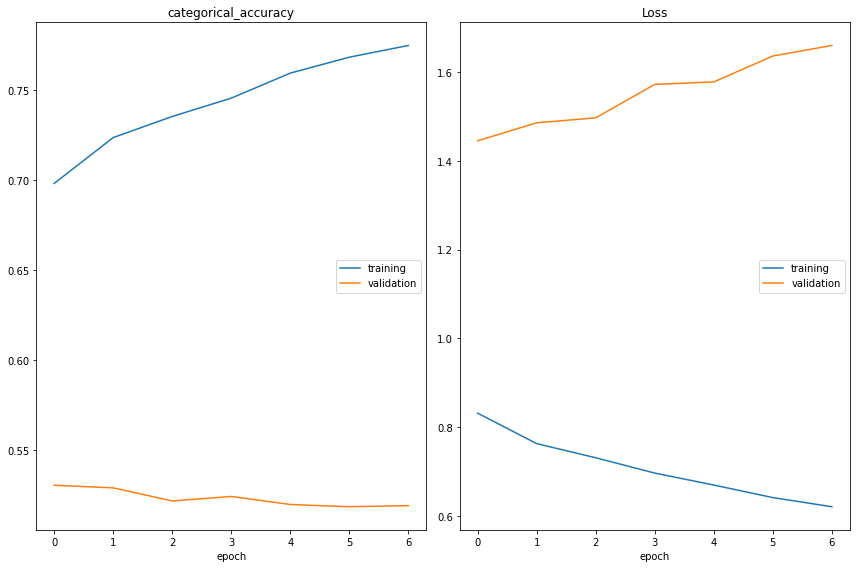

categorical_accuracy
	training         	 (min:    0.698, max:    0.775, cur:    0.775)
	validation       	 (min:    0.519, max:    0.531, cur:    0.519)
Loss
	training         	 (min:    0.620, max:    0.831, cur:    0.620)
	validation       	 (min:    1.446, max:    1.661, cur:    1.661)

Epoch 7: val_categorical_accuracy did not improve from 0.53055
302/302 [==============================] - 422s 1s/step - loss: 0.6202 - categorical_accuracy: 0.7748 - val_loss: 1.6605 - val_categorical_accuracy: 0.5192


In [ ]:
EPOCHS = 7
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint])

Точность незначительно повысилась на валидационной выборке до 0.53055

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_all')
model.load_weights(cpt_path_weights)

###Заморозим все слои, кроме последних двух. Попробуем до обучить последние слои - может быть получится лучше распознавать объекты.

In [ ]:
output_weights = Path("/content/drive/My Drive/weights_VGG19")
output_weights.mkdir(exist_ok=True)
file_name_weights = 'weights_VGG19_end.h5'
cpt_path_weights_end = str(output_weights / file_name_weights)  # создадим новый путь для итоговых весов

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    cpt_path_weights_end,
    monitor='val_categorical_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
model.layers

In [ ]:
model.trainable = False  # заморозим веса
model.layers[2].trainable = True  # разморозим веса для обучения последнего слоя

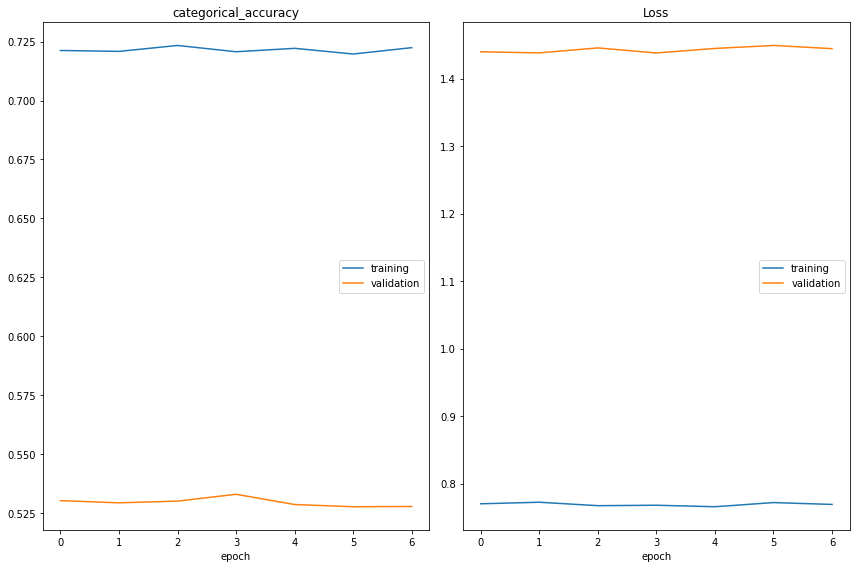

categorical_accuracy
	training         	 (min:    0.720, max:    0.723, cur:    0.722)
	validation       	 (min:    0.528, max:    0.533, cur:    0.528)
Loss
	training         	 (min:    0.766, max:    0.772, cur:    0.769)
	validation       	 (min:    1.438, max:    1.449, cur:    1.444)

Epoch 7: val_categorical_accuracy did not improve from 0.53284
302/302 [==============================] - 379s 1s/step - loss: 0.7692 - categorical_accuracy: 0.7224 - val_loss: 1.4444 - val_categorical_accuracy: 0.5276


In [ ]:
EPOCHS = 7
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback(), checkpoint])

Подгружаем веса с наилучшей точностью валидационных данных и сохраняем модель.

In [ ]:
model.load_weights(cpt_path_weights_end)

In [ ]:
model.save('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_itog')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/vgg19_itog/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/vgg19_itog/assets


#Оптимизация модели с помощью TensorRT

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
%tensorflow_version 1.x  # переход на более старую версию - не помог
import tensorflow as tf

tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

Код на дату 09.08.2022 не работает

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [ ]:
output = Path("/content/drive/My Drive/model")
output.mkdir(exist_ok=True)
cpt_filname_itog = 'VGG19itog_trt'
cpt_path_itog = str(output / cpt_filname_itog)

In [ ]:
converter = trt.TrtGraphConverterV2(input_saved_model_dir='/content/drive/MyDrive/DS_identity_emotions/model/vgg19_itog')
converter.convert()
converter.save(cpt_path_itog)

ERROR:tensorflow:Tensorflow needs to be built with TensorRT support enabled to allow TF-TRT to operate.


RuntimeError: ignored